## scRNA subcluster and trajectory analysis

In [ ]:
library(Seurat)
library(tidyverse)
library(monocle)

In [ ]:
load('~/DATA/code/myCode/scRNA.rdata')
col<-c('Hepatocyte'="#1F78B4",'Endothelial'="#B2DF8A",'B'="#E31A1C",
       'Myeloid'="#FDBF6F",'T/NK'="#6A3D9A",'Fibroblast'="#A6761D")

DimPlot(scRNA, reduction = "umap",group.by = "celltype",label = T,cols = col)

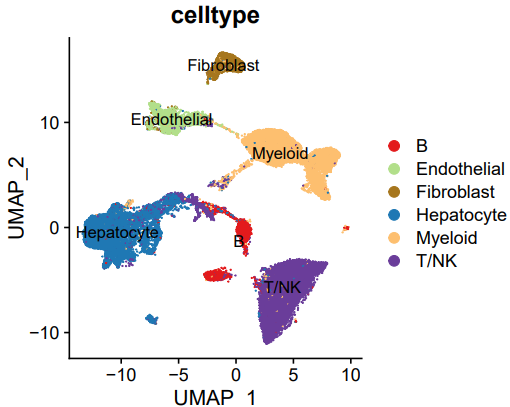

## 提取Myeloid细胞并重新分群

In [ ]:
Myeloid<-subset(scRNA, celltype %in% c( 'Myeloid' ))
##创建Seurat对象
Myeloid<-CreateSeuratObject(counts = Myeloid@assays$RNA@counts,
                       meta.data = Myeloid@meta.data)

#筛选高可变基因，并进行数据降维
Myeloid <- NormalizeData(Myeloid) %>% 
  FindVariableFeatures(selection.method = "vst",nfeatures = 2000) %>% 
  ScaleData() %>% 
  RunPCA(npcs = 30, verbose = T)

In [ ]:
library(harmony)
##使用harmony进行整合&批次矫正 
Myeloid <- RunHarmony(Myeloid,reduction = "pca",group.by.vars = "orig.ident",reduction.save = "harmony")
#非线性降维，UMAP和tSNE 是Seurat进行非线性降维的方法，首选 UMAP
Myeloid <- RunUMAP(Myeloid, reduction = "harmony", dims = 1:20,reduction.name = "umap")
#查看去批次效果
DimPlot(Myeloid, reduction = "umap",group.by = "orig.ident")

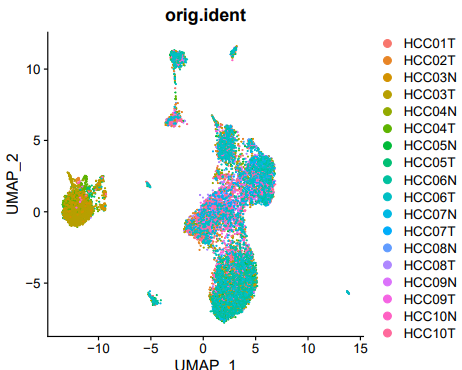

In [ ]:
##识别细胞簇(cluster)
Myeloid <- FindNeighbors(Myeloid, reduction = "harmony", dims = 1:20) %>% 
  FindClusters(resolution = 0.4)  

DimPlot(Myeloid,reduction = "umap",label=T)

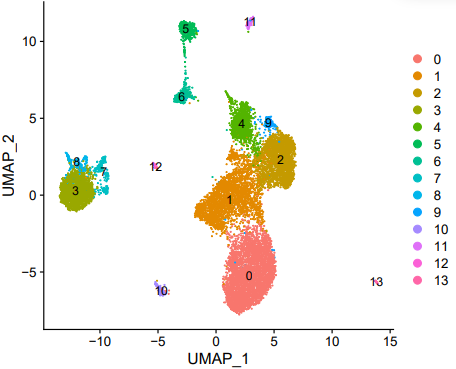

## SingleR亚群注释

In [ ]:
library(SingleR)
#载入参考数据集
ref_use <- load("/home/zhaojingwei/R/data/HumanPrimaryCellAtlas_hpca.se_human.RData") 

pred <- SingleR(test=as.matrix(Myeloid@assays$RNA@data),       #输入表达矩阵
                ref=hpca.se,                                #参考数据
                labels=hpca.se$label.main,                  #标签列
                clusters = Myeloid$seurat_clusters) 

celltype = data.frame(ClusterID=rownames(pred), celltype=pred$labels, stringsAsFactors = F)
Myeloid$singleR=celltype[match((Myeloid$seurat_clusters),celltype$ClusterID),'celltype']

cols = c("#7fc97f","#beaed4","#fdc086","#386cb0","#f0027f"
         ,"#a34e3b","#666666","#1b9e77","#d95f02","#6c67a5"
         ,"#d01b2a", "#43acde", "#efbd25","#1f78b4")

DimPlot(Myeloid,group.by = 'singleR',cols = cols)

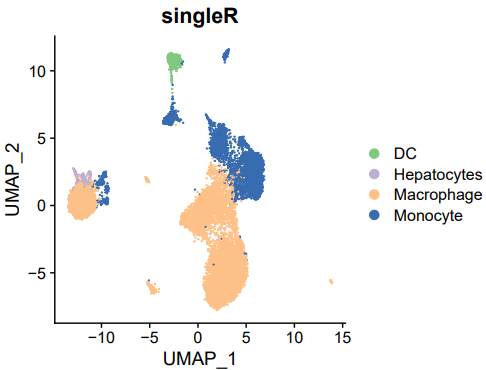

In [ ]:
##marker基因
Marker = list('Mono'=c('S100A8','FCN1','S100A9'),
              'Mac'=c('CD68','CD163'),
              'Hep'=c('ALB','SERPINA1','HNF4A'),
              'DC' =c('CD83','CST3'))

#气泡图
DotPlot(Myeloid,features=Marker,cols = c('#EEE9E9','#5D478B'),group.by='singleR') +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

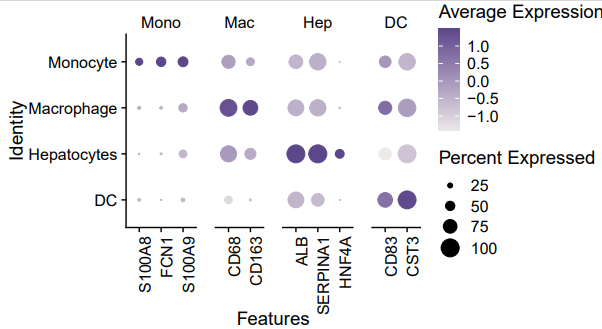

## monocle2 轨迹分析

In [ ]:
##分化轨迹
library(monocle)
library(tidyverse)
library(RColorBrewer)

table(Myeloid$singleR)
##剔除非Myeliod细胞
subMyeloid <- subset(Myeloid, singleR %in% c('DC','Macrophage','Monocyte'))
subMyeloid$Celltype<-subMyeloid$singleR
DimPlot(subMyeloid,group.by = 'Celltype',cols = cols)

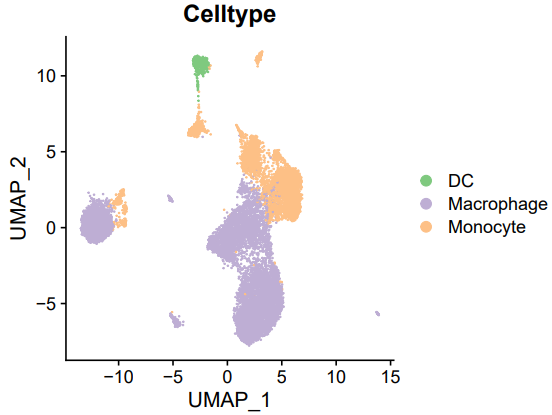

In [ ]:
##获取原始表达矩阵
data<- as(as.matrix(subMyeloid@assays$RNA@counts),'sparseMatrix')
#构建mycds对象
pd <- new('AnnotatedDataFrame',data = subMyeloid@meta.data)
fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame',data = fData )

##将p_data和f_data从data.frame转换AnnotatedDataFrame对象
mycds<- newCellDataSet(data,
                       phenoData = pd,
                       featureData = fd,
                       expressionFamily = negbinomial.size())#从seurat到monocle

##估计size factor和离散度
mycds <- estimateSizeFactors(mycds)
mycds <- estimateDispersions(mycds,cores=8,relative_expr = TRUE)

##过滤低质量的细胞
disp_table <- dispersionTable(mycds)
#用于排序的基因数目
disp.genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)$gene_id

##轨迹构建基因可视化
mycds <- setOrderingFilter(mycds,disp.genes)
##降维
mycds <- reduceDimension(mycds, max_components = 2,method ='DDRTree')

##默认排序
mycds<-orderCells(mycds)#排序

##Pseudotime轨迹
Pseudotime<-plot_cell_trajectory(mycds, color_by="Pseudotime",cell_size = 1)
Pseudotime
ggsave("monocle/traject_state.pdf", plot = Pseudotime, width = 6.6, height = 5)

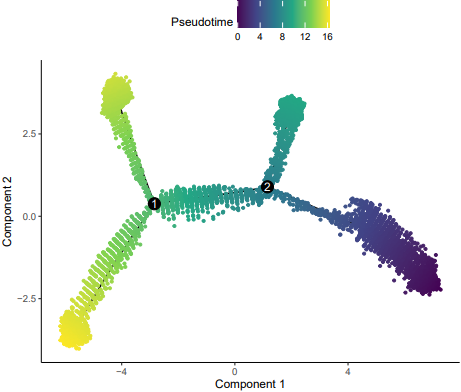

In [ ]:
##Celltype轨迹分布
plot_cell_trajectory(mycds, color_by="Celltype",cell_size = 1)+ scale_color_manual(values = col)

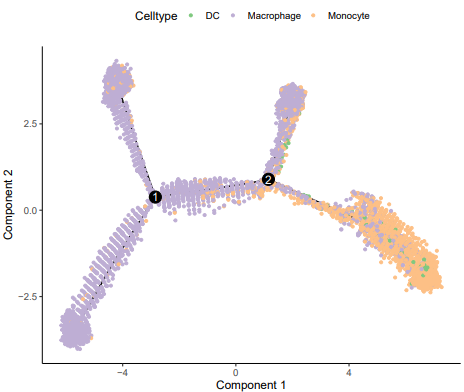

In [ ]:
##state轨迹
plot_cell_trajectory(mycds, color_by = "State",cell_size = 1)

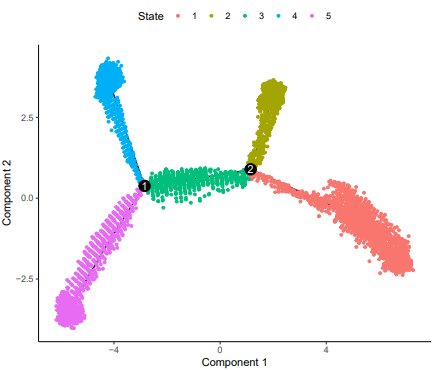

In [ ]:
tree<-plot_complex_cell_trajectory(mycds,x = 1, y = 2,
                                   color_by = "State")


tree

In [ ]:
##沿时间轴的细胞密度图
library(ggpubr)
df <- pData(mycds) 
ggplot(df, aes(Pseudotime, colour = Celltype, fill=Celltype)) +
       geom_density(bw=0.5,size=1,alpha = 0.8)+theme_classic2()+ 
       scale_fill_manual(name= "", values = cols)+
       scale_color_manual(name = "", values = cols)

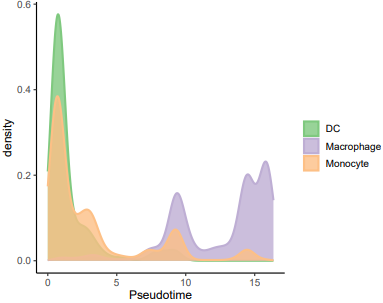

In [ ]:
##TOP基因的可视化
keygenes <- head(disp.genes,4)
cds_subset <- mycds[keygenes,]
p1<-plot_genes_in_pseudotime(cds_subset,color_by = "Pseudotime")+
                  scale_color_viridis_c(option = "viridis")
p2<-plot_genes_in_pseudotime(cds_subset,color_by = "Celltype")+ scale_color_manual(values = cols)
p1+p2

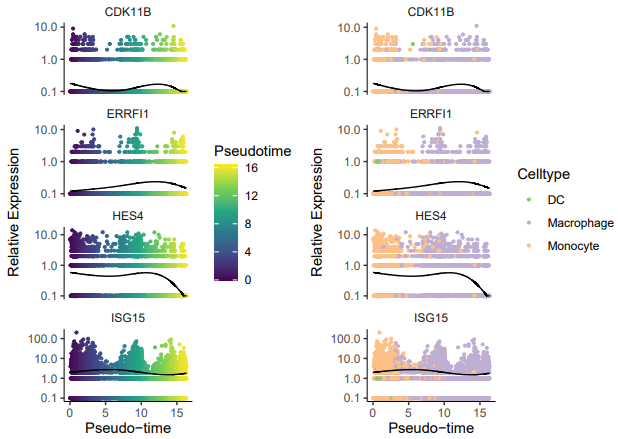

In [ ]:
##轨迹图展示基因表达
library(ggsci)
colnames(pData(mycds))
pData(mycds)$S100A9 = log2( exprs(mycds)['S100A9',]+1)
p3<-plot_cell_trajectory(mycds, color_by ="S100A9",cell_size = 0.8)   + scale_color_gsea()
pData(mycds)$CD163 = log2( exprs(mycds)['CD163',]+1)
p4<-plot_cell_trajectory(mycds, color_by ="CD163",cell_size = 0.8)   + scale_color_gsea()
p3+p4

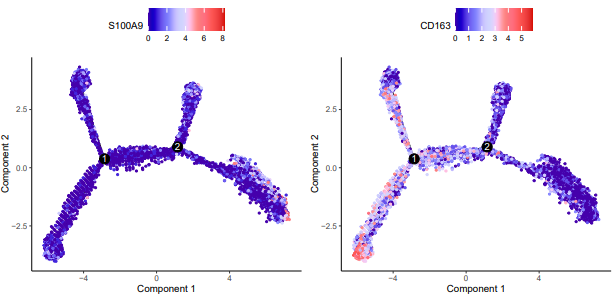

## 拟时序通路得分

In [ ]:
#导入基因集
geneset = clusterProfiler::read.gmt("~/DATA/luo/BD/metabolic/pathway/Hallmark.2023.2.Hs.symbols.gmt")
geneset = split(geneset$gene,geneset$term)

##AddModuleScore
subMyeloid = AddModuleScore(subMyeloid,
                            features = geneset["HALLMARK_OXIDATIVE_PHOSPHORYLATION"],
                            name = 'HALLMARK_OXIDATIVE_PHOSPHORYLATION')
colnames(subMyeloid@meta.data)[18] <- 'OXIDATIVE_PHOSPHORYLATION'
subMyeloid$CB<-rownames(subMyeloid@meta.data)

#将打分结果合并到monocle对象的对应矩阵中
scoredf = subMyeloid@meta.data[,c(18:19)]
mycds@phenoData@data$CB<-rownames(mycds@phenoData@data)
pData(mycds) = pData(mycds) %>% inner_join(scoredf,by = "CB")
rownames(pData(mycds)) = pData(mycds)[,"CB"]

plot_cell_trajectory(mycds,color_by = "OXIDATIVE_PHOSPHORYLATION",cell_size = 1)+
  scale_color_viridis_c(option = "viridis")+
  theme(legend.position = "top")

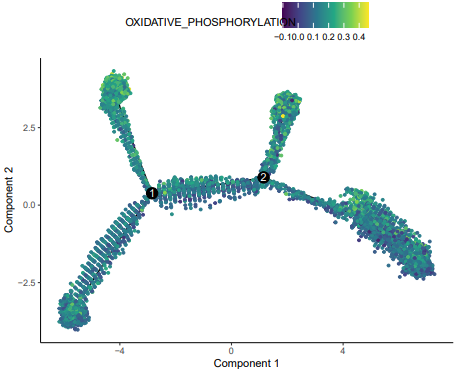

## 轨迹分支分析

In [ ]:
#选择感兴趣的节点进行BEAM统计分析
BEAM_res <- BEAM(mycds, branch_point = 1, cores = 8)#会返回各基因的显著性，显著的基因就是那些随不同branch变化的基因
BEAM_res <- BEAM_res[order(BEAM_res$qval),]
BEAM_res <- BEAM_res[,c("gene_short_name", "pval", "qval")]

#保存节点
saveRDS(BEAM_res,file = 'monocle/NC/BEAM_res.rds')
BEAM_res<-readRDS('BEAM_res.rds')

In [ ]:
#热图可视化
library(RColorBrewer)
tmp1=plot_genes_branched_heatmap(mycds[row.names(subset(BEAM_res,qval<1e-4)),],
                                 branch_point = 1,
                                 num_clusters = 3, #这些基因被分成几个group
                                 cores = 8,
                                 branch_labels = c("Cell fate 1", "Cell fate 2"),
                                 #hmcols = NULL, #默认值
                                 hmcols = colorRampPalette(rev(brewer.pal(9, "PRGn")))(62),
                                 branch_colors = c("#979797", "#F05662", "#7990C8"), #pre-branch, Cell fate 1, Cell fate 2分别用什么颜色
                                 use_gene_short_name = T,
                                 show_rownames = F,
                                 return_heatmap = T #是否返回一些重要信息
)

pdf("3branched_heatmap.pdf",width = 5,height = 6)
tmp1$ph_res
dev.off()

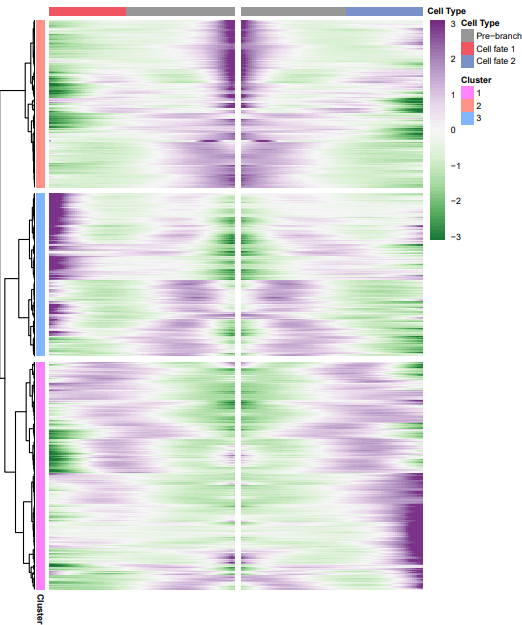

In [ ]:
##获取各Cluster基因
geneCluster=tmp1$annotation_row
geneCluster$gene=rownames(geneCluster)
#保存不同branch基因名
write.csv(geneCluster,file = 'NC-branch-geneCluster.csv')

In [ ]:
## 拟时序Cluster_GO富集分析
library(clusterProfiler)
library(org.Hs.eg.db)
library(tidyverse)

gid <- bitr(unique(geneCluster$gene), 'SYMBOL', 'ENTREZID', OrgDb= 'org.Hs.eg.db')  # 人 Hs 鼠 Mm
Genelist <- full_join(geneCluster, gid, by=c('gene' = 'SYMBOL'))
#删除未转换成功ID的基因行
Genelist <- Genelist[!is.na(Genelist$ENTREZID),]

##GO:BP Enrichment
GO_BP = compareCluster(ENTREZID ~ Cluster, 
                       data = Genelist, 
                       fun='enrichGO',
                       OrgDb = 'org.Hs.eg.db',
                       ont = "BP") 

dotplot(GO_BP, label_format=40,showCategory=5) + 
  theme(axis.text.x = element_text(angle=45, hjust=1)) + 
  ggtitle('GO Enrichment') +  
  scale_color_gradientn(colours = colorRampPalette(colors = brewer.pal(11, name = "RdBu"))(11))

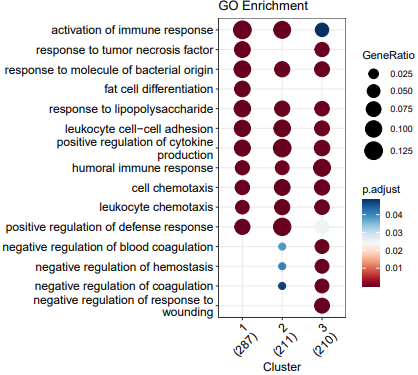

In [ ]:
#将EntrezID转换为Symbol
GO_BP = setReadable(GO_BP, #前面分析的结果
                    OrgDb = "org.Hs.eg.db", #人类数据库
                    keyType = "ENTREZID") #要转换的基因类型

#保存GO富集结果
write.csv(GO_BP@compareClusterResult,file = 'Myeloid_diff_cluster_GO_BP.csv')

### Written by :孟德尔的豌豆